#### Домашнее задание № 4 

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [2]:
import pandas as pd


#### 1. скачать набор данных маркетинговых кампаний

In [3]:
df = pd.read_csv('./HW_data.csv')
df


,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


#### 2. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [4]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df


,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  object 
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [6]:
df.treatment.unique()


array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [7]:
treatment_dict = {'Buy One Get One': 1, 'No Offer': 0, 'Discount': 1}
df.treatment = df.treatment.map(treatment_dict)


In [8]:
df.treatment.value_counts()


1    42694
0    21306
Name: treatment, dtype: int64

#### 4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

рассмотрим категориальные признаки:

In [11]:
df.zip_code.unique()


array(['Surburban', 'Rural', 'Urban'], dtype=object)

In [12]:
df.channel.unique()


array(['Phone', 'Web', 'Multichannel'], dtype=object)

поскольку предполагаем использовать CatBoost можем оставить эти признаки как есть...

In [13]:
cat_features = ['zip_code', 'channel']


можем нормализовать значения признака 'hist'

#### 3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
features = ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code','is_referral', 'channel']
treatment = 'treatment'
target = 'target'

indices_train, indices_test = train_test_split(df.index, test_size=0.3, random_state=0)

In [16]:
X_train = df.loc[indices_train, features]
y_train = df.loc[indices_train, target]
treat_train = df.loc[indices_train, treatment]
X_test = df.loc[indices_test, features]
y_test = df.loc[indices_test, target]
treat_test = df.loc[indices_test, treatment]
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

#### 5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

#### 1 модель

In [29]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
import numpy as np

In [30]:
parameters_cb = {
     'n_estimators': [100, 150, 200, 600, 1000],
     'max_depth': np.arange(2, 10, 2),
 }
clf = RandomizedSearchCV(
    estimator=CatBoostClassifier(
        cat_features=cat_features, random_state=0, silent=True
    ),
    param_distributions=parameters_cb,
    scoring='roc_auc',
    cv=5
)
clf.fit(X_train, y_train)
clf.best_params_

c:\Users\azhur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
14 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\azhur\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\azhur\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py", line 5128, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best

{'n_estimators': 200, 'max_depth': 2}

In [31]:
sm = SoloModel(CatBoostClassifier(n_estimators=600, max_depth=2, cat_features=cat_features, random_state=0, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)
uplift_sm

array([0.06356219, 0.06033471, 0.06911576, ..., 0.03830526, 0.05239249,
       0.06880512])

In [33]:
sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_10

0.06756833180883814

In [34]:
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
sm_score_20

0.07104276760476835

In [35]:
models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

array([<AxesSubplot: title={'center': 'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot: title={'center': 'Control predictions'}>,
       <AxesSubplot: title={'center': 'Uplift predictions'}>],
      dtype=object)

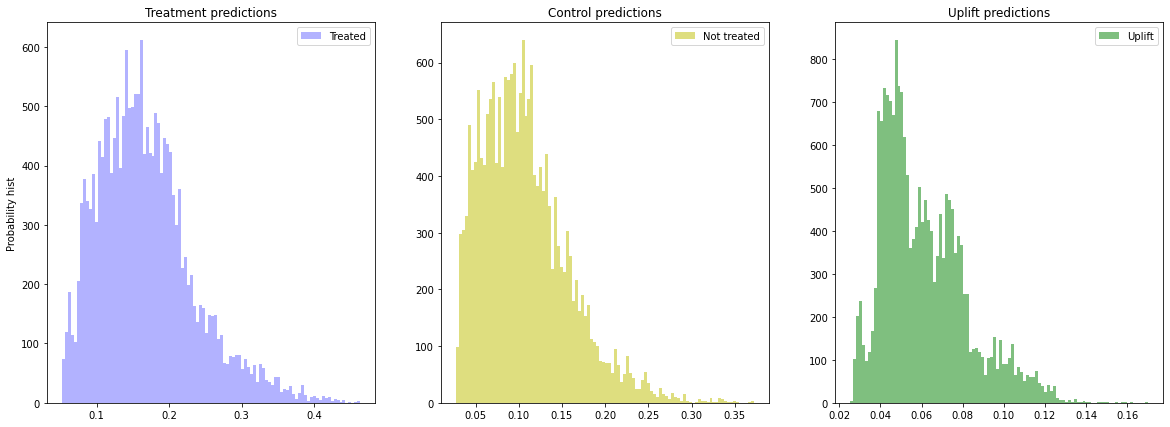

In [36]:
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)

In [37]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,19.574058
1,is_referral,18.256027
2,history,15.370429
3,recency,14.479461
4,used_bogo,12.971668
5,used_discount,7.806184
6,zip_code,7.062990
7,channel,4.479183


#### Трансформация классов

In [38]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(n_estimators=600, max_depth=2, cat_features=cat_features, random_state=0, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

In [39]:
ct_score_10

0.08250100813391953

In [40]:
ct_score_20

0.07479630084797836

#### Важность признаков

In [41]:
ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

ct_fi

,feature_name,feature_score
0,history,36.291617
1,used_bogo,17.096982
2,recency,10.930662
3,zip_code,10.828212
4,channel,10.091386
5,used_discount,8.475119
6,is_referral,6.286023


#### 2 модели

array([<AxesSubplot: title={'center': 'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot: title={'center': 'Control predictions'}>,
       <AxesSubplot: title={'center': 'Uplift predictions'}>],
      dtype=object)

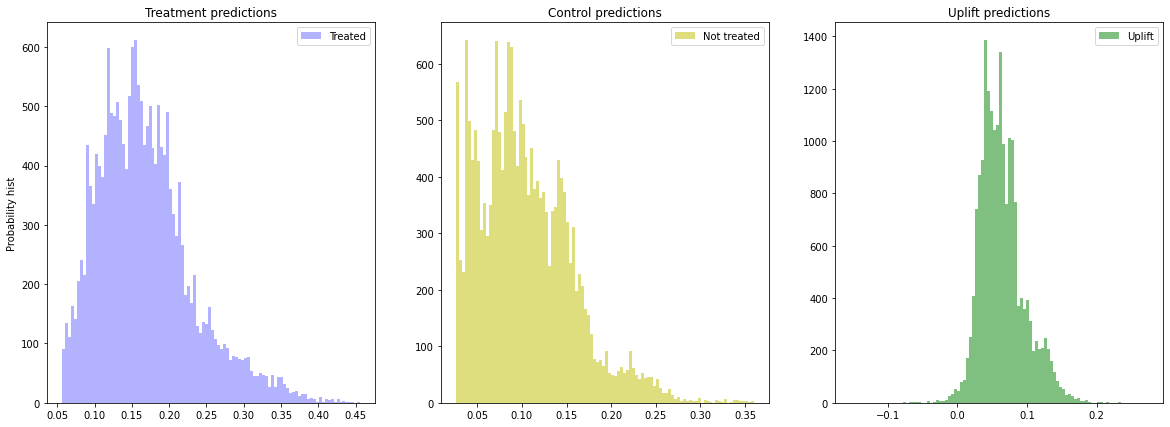

In [42]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(n_estimators=600, max_depth=2, cat_features=cat_features, random_state=0, silent=True), 
    estimator_ctrl=CatBoostClassifier(n_estimators=600, max_depth=2, cat_features=cat_features, random_state=0, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

In [43]:
tm_score_10

0.08264239276897503

In [44]:
tm_score_20

0.08139977878825119

#### Важность признаков для первой модели

In [45]:
tm_fi_trmnt = pd.DataFrame({
    'feature_name': tm.estimator_trmnt.feature_names_,
    'feature_score': tm.estimator_trmnt.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

tm_fi_trmnt

,feature_name,feature_score
0,used_bogo,23.425865
1,history,18.995933
2,is_referral,18.958181
3,recency,14.233134
4,used_discount,12.234753
5,zip_code,7.651182
6,channel,4.500952


#### Важность признаков для контрольной группы

In [46]:
tm_fi_ctrl = pd.DataFrame({
    'feature_name': tm.estimator_ctrl.feature_names_,
    'feature_score': tm.estimator_ctrl.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

tm_fi_ctrl

,feature_name,feature_score
0,is_referral,29.484240
1,recency,22.459030
2,history,19.513584
3,zip_code,13.111895
4,channel,6.506935
5,used_discount,4.646015
6,used_bogo,4.278301


#### 6.вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [47]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
2,TwoModels,0.082642,0.081400
1,ClassTransformation,0.082501,0.074796
0,SoloModel,0.067568,0.071043
